### HW5 - F3CV
### Name: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

#### Q1: Canny Edge Detection

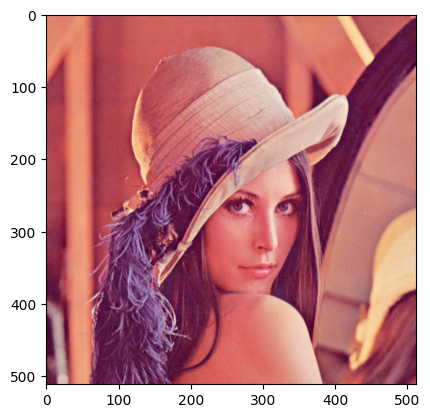

In [17]:
# Open Lena.png image
img = Image.open('Lena.png')
img = np.asarray(img)
plt.imshow(img)

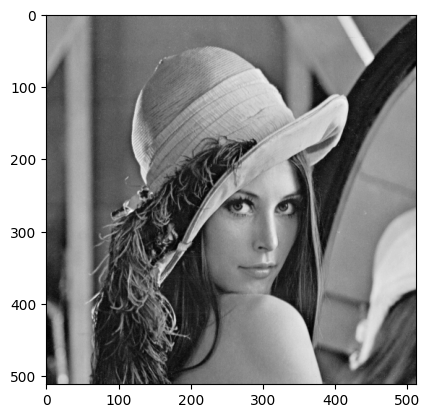

In [18]:
# Gray scale the image
def gray_scale(img):
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    gray_img = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray_img
img_gray = gray_scale(img)
plt.imshow(img_gray, cmap='gray')

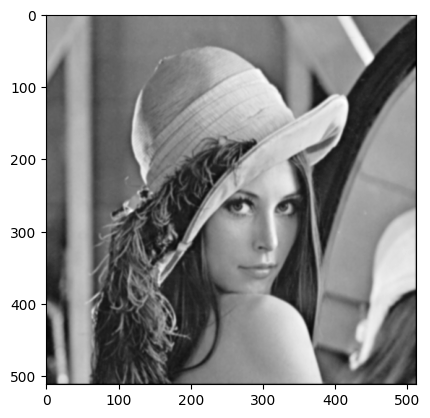

In [19]:
# Noise reduction using Gaussian filter
def conv2D(img, kernel):
        output_img = np.zeros(img.shape)
        img = np.pad(img, (kernel.shape[0]//2, kernel.shape[1]//2), 'constant')
        for i in range(output_img.shape[0]):
            for j in range(output_img.shape[1]):
                output_img[i, j] = np.sum(img[i:i+kernel.shape[0], j:j+kernel.shape[1]] * kernel)
        return output_img

def reduce_noise(img, kernel_size=5):
    sigma = 1
    kernel_size = 5
    x, y = np.meshgrid(np.linspace(-(kernel_size//2), kernel_size//2, kernel_size), np.linspace(-(kernel_size//2), kernel_size//2, kernel_size))
    guaussian_kernel = 1/(2*np.pi*sigma**2)*np.exp(-((x**2+y**2)/(2*sigma**2)))
    denoised_img = conv2D(img, guaussian_kernel)
    return denoised_img


img_denoised = reduce_noise(img_gray)
plt.imshow(img_denoised, cmap='gray')


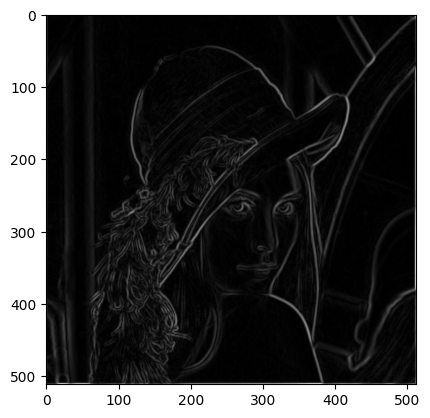

In [20]:
# Gradient calculation
def gradient_calc(img):
    sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    grad_x = conv2D(img, sobel_x)
    grad_y = conv2D(img, sobel_y)
    grad = np.sqrt(grad_x**2 + grad_y**2)
    grad = grad/grad.max() * 255
    theta = np.arctan2(grad_y, grad_x)
    return grad, theta

img_grad, theta = gradient_calc(img_denoised)
plt.imshow(img_grad, cmap='gray')

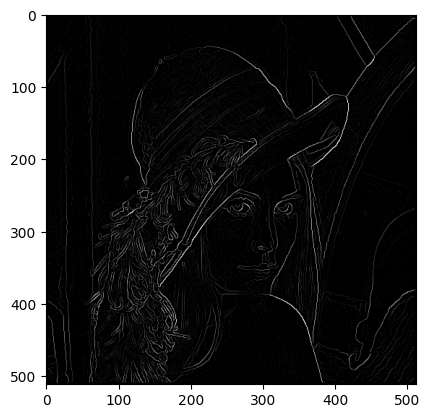

In [21]:
# Non-maximum suppression
def non_max_suppression(img, theta):
    non_max_suppressed_img = np.zeros(img.shape)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            adj_1 = 255
            adj_2 = 255
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                adj_1 = img[i, j+1]
                adj_2 = img[i, j-1]
            elif (22.5 <= angle[i, j] < 67.5):
                adj_1 = img[i+1, j-1]
                adj_2 = img[i-1, j+1]
            elif (67.5 <= angle[i, j] < 112.5):
                adj_1 = img[i+1, j]
                adj_2 = img[i-1, j]
            elif (112.5 <= angle[i, j] < 157.5):
                adj_1 = img[i-1, j-1]
                adj_2 = img[i+1, j+1]
            if (img[i, j] >= adj_1) and (img[i, j] >= adj_2):
                non_max_suppressed_img[i, j] = img[i, j]
    return non_max_suppressed_img

img_suppressed = non_max_suppression(img_grad, theta)
plt.imshow(img_suppressed, cmap='gray')


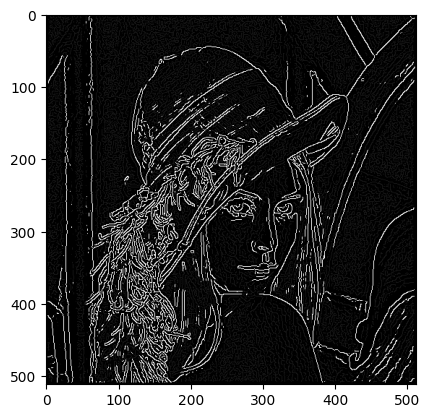

In [22]:
# Double thresholding and hysteresis
def double_thresholding(img, low_threshold_rate=0.05, high_threshold_rate=0.09):
    high_threshold = img.max() * high_threshold_rate
    low_threshold = high_threshold * low_threshold_rate
    result_img = np.zeros(img.shape)
    weak = 25
    strong = 255
    result_img[img >= high_threshold] = strong
    result_img[(img <= high_threshold) & (img >= low_threshold)] = weak
    return result_img

img_thresholded = double_thresholding(img_suppressed)
plt.imshow(img_thresholded, cmap='gray')

#### Q2: Harris Key Point Detector

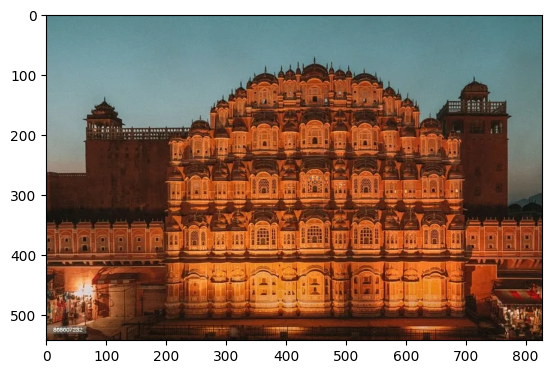

In [23]:
# Open Harris.png
img = Image.open('Harris.png')
img = np.asarray(img)
plt.imshow(img)

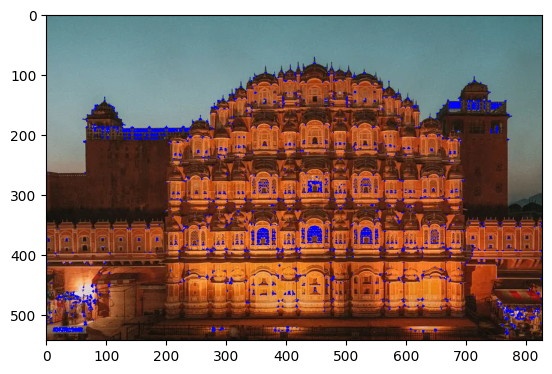

In [24]:
# Harris detector from scratch
def harris_detector(img):
    img = gray_scale(img)
    #compute x and y derivatives of image
    sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    I_x = conv2D(img, sobel_x)
    I_y = conv2D(img, sobel_y)
    #compute products of derivatives at every pixel
    I_x2 = I_x * I_x
    I_y2 = I_y * I_y
    I_xy = I_x * I_y
    #compute the weighted sums of the products of derivatives at each pixel
    guassian_kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/16
    S_x2 = conv2D(I_x2, guassian_kernel)
    S_y2 = conv2D(I_y2, guassian_kernel)
    S_xy = conv2D(I_xy, guassian_kernel)
    #Define the matrix H at each pixel
    H = np.zeros(shape=(img.shape[0], img.shape[1], 2, 2))
    H[:,:,0,0] = S_x2
    H[:,:,0,1] = S_xy
    H[:,:,1,0] = S_xy
    H[:,:,1,1] = S_y2
    #Compute the response of the detector at each pixel
    R = np.zeros(shape=(img.shape[0], img.shape[1]))
    k = 0.05
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            R[i,j] = np.linalg.det(H[i,j,:,:]) - k * (np.trace(H[i,j,:,:]))**2
    return R

R = harris_detector(img)
harris_img_from_scratch = img.copy()
harris_img_from_scratch[R > 0.01 * R.max()] = [0, 0, 255]
    
plt.imshow(harris_img_from_scratch.astype(np.uint8))

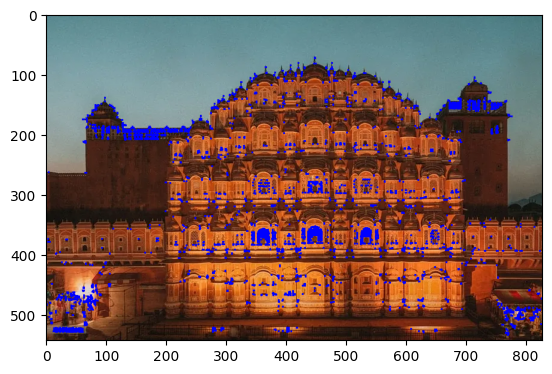

In [25]:
# Harris detector using OpenCV
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray, 2, 3, 0.05)
dst = cv2.dilate(dst, None)
harris_img_opencv = img.copy()
harris_img_opencv[dst > 0.01 * dst.max()] = [0, 0, 255]
plt.imshow(harris_img_opencv.astype(np.uint8))

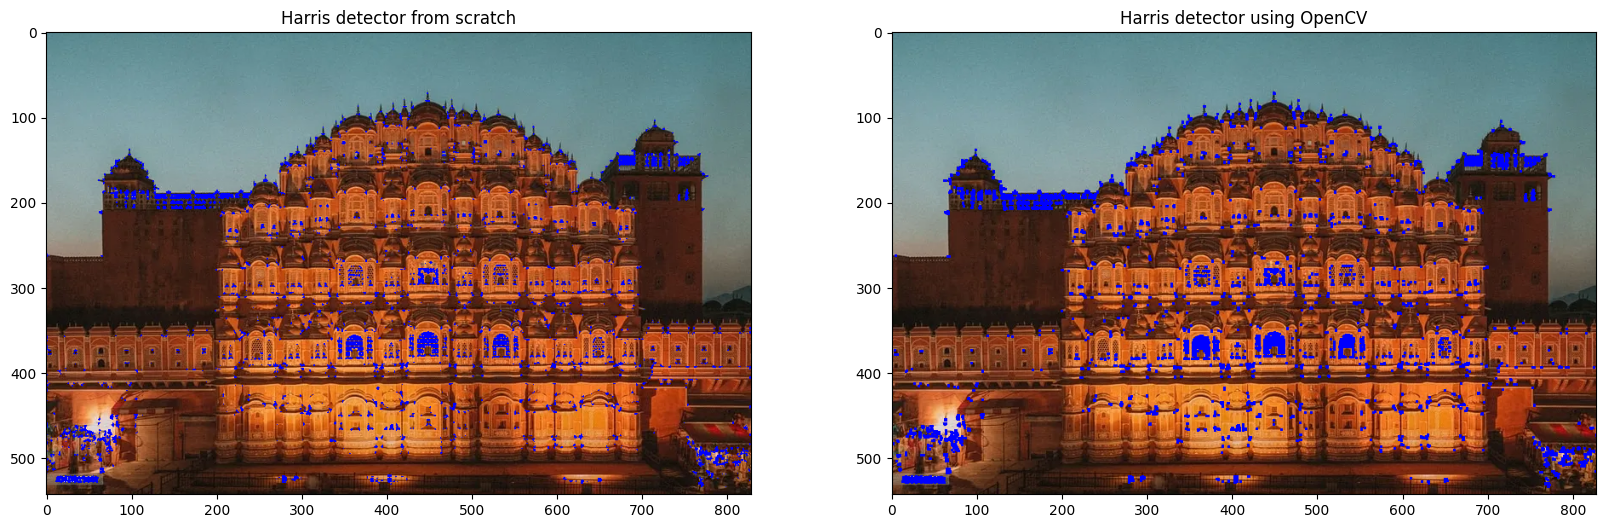

In [26]:
# Compare the results of Harris detector from scratch and OpenCV
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(harris_img_from_scratch.astype(np.uint8))
ax[0].set_title('Harris detector from scratch')
ax[1].imshow(harris_img_opencv.astype(np.uint8))
ax[1].set_title('Harris detector using OpenCV')
plt.show()

#### Q3: MSER

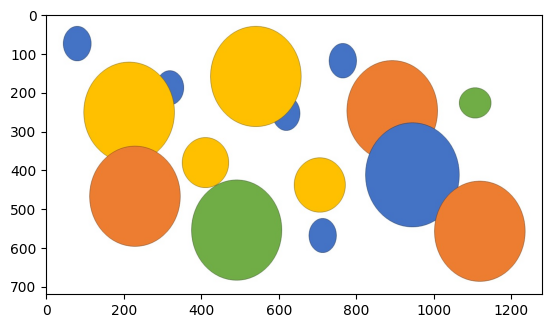

In [27]:
# Open img3.jpg
img = cv2.imread('img3.jpg')
plt.imshow(img[:,:,::-1])

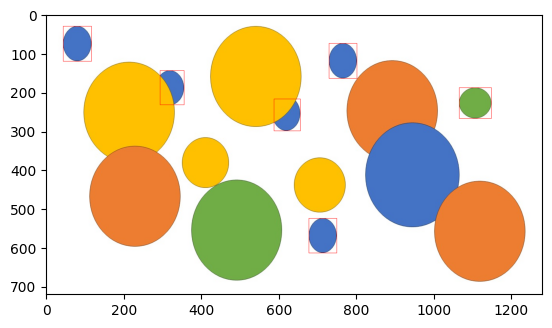

In [28]:
# MSER
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mser = cv2.MSER_create(delta=25, max_variation=0.07, min_area=200, max_area=10000)
regions, _ = mser.detectRegions(gray)
img_mser = img.copy()
for region in regions:
    x, y, w, h = cv2.boundingRect(region)
    cv2.rectangle(img_mser, (x, y), (x+w, y+h), (0, 0, 255), 1)
plt.imshow(img_mser[:,:,::-1])

##### Reported final hyperparameters: delta=25, max_variation=0.07, min_area=200, max_area=10000

#### Q4: SIFT

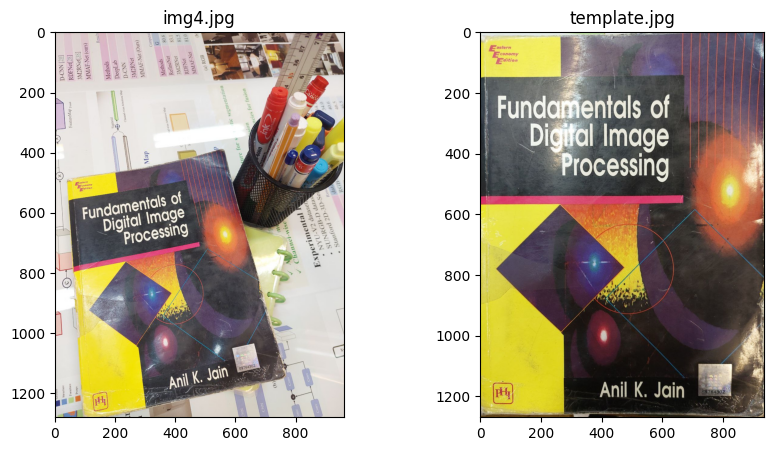

In [29]:
# Open img4.jpg and template.jpg
img = cv2.imread('img4.jpg')
template = cv2.imread('template.jpg')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[:,:,::-1])
ax[0].set_title('img4.jpg')
ax[1].imshow(template[:,:,::-1])
ax[1].set_title('template.jpg')
plt.show()

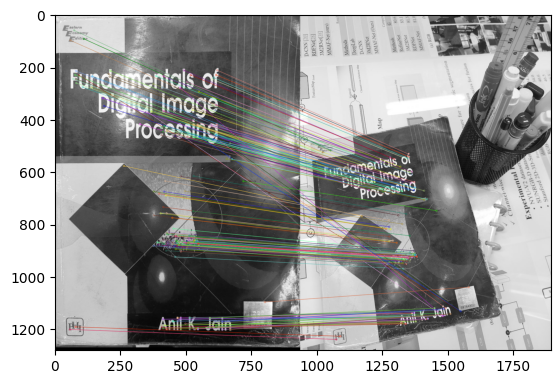

In [37]:
#SIFT feature matching
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_template, None)
kp2, des2 = sift.detectAndCompute(gray_img, None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
good_matches = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good_matches.append([m])
img_sift = cv2.drawMatchesKnn(gray_template, kp1, gray_img, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_sift[:,:,::-1])